In [ ]:
import os
os.getcwd()

In [1]:
import sys
import os

#####################
# Import of utils.py functions
#####################
root_dir = os.getcwd()
sys.path.append('.')
from utils import loadFSL, FSLeyesServer

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################

# ???
# os.environ["DIPY_HOME"] = "/home/jovyan/Data"

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries
##################
import fsl.wrappers
from fsl.wrappers import fslmaths, flirt, fast, bet, mcflirt, epi_reg, fslroi
from fsl.wrappers.misc import fslroi
import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
# Cleanup previously defined data
os.system("rm -rf dataset/derivatives")

0

In [2]:
%gui wx

Gtk-Message: 10:36:59.653: Failed to load module "canberra-gtk-module"


In [3]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

10:37:03: Debug: Adding duplicate image handler for 'Windows bitmap file'
10:37:03: Debug: Adding duplicate animation handler for '1' type
10:37:03: Debug: Adding duplicate animation handler for '2' type
10:37:03: Debug: Adding duplicate image handler for 'Windows bitmap file'
10:37:03: Debug: Adding duplicate animation handler for '1' type
10:37:03: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:402): Gtk-CRITICAL **: 10:37:04.088: gtk_window_resize: assertion 'height > 0' failed


# Part 1: Preprocessing

In [4]:
# Creating derivative root and saving some useful paths
subject = "subject101410"

bids_root = op.join(root_dir, "dataset")
subject_root = op.join(bids_root, subject)

derivatives_root = op.join(bids_root, "derivatives")
os.makedirs(derivatives_root, exist_ok=True)
preproc_root = op.join(derivatives_root, "preprocessed_data")
os.makedirs(preproc_root, exist_ok=True)
subject_preproc_root = op.join(preproc_root, subject)
os.makedirs(subject_preproc_root, exist_ok=True)

anat_path = op.join(subject_root, "T1w", "T1w.nii.gz")

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anat_path)


(ipykernel_launcher.py:408): Gdk-WARNING **: 10:27:21.223: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## Skull stripping

In [ ]:
# To display the commands and how to use the "bet" command
os.system("bet -h")

In [7]:
# Skull stripping with "bet"
robust: bool = True

# Define the path where to save the file
os.makedirs(op.join(subject_preproc_root, "T1w"), exist_ok=True)
betted_brain_path = op.join(subject_preproc_root, "T1w", "T1w_skull.nii.gz")

# Apply "bet" and save the file
robust_text = "-R" if robust else ""
os.system(f"bet {anat_path} {betted_brain_path} -m {robust_text}")

# BET also creates a resulting Mask that is useful to display
resulting_mask = op.join(subject_preproc_root, "T1w", "T1w_skull_mask.nii.gz")

print("Skull stripping with BET succeeded!")

Skull stripping with BET succeeded!


In [8]:
# Display the Skull Stripped Image
fsleyesDisplay.load(resulting_mask)

In [9]:
# Now we have to apply the mask to the image
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system(f'fslmaths {img_path} -mas {mask_path} {masked_img_path}')

apply_fsl_math_approach(anat_path, resulting_mask, betted_brain_path)

In [10]:
# Comparison between T1 and skull stripped
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anat_path)
fsleyesDisplay.load(betted_brain_path)

## Tissue segmentation

In [ ]:
os.system("fast -h")

In [11]:
# tissue segmentation
import time

start = time.time()
fast_output_path = op.join(subject_preproc_root, "T1w", "T1w_fasted")
fast_target = betted_brain_path 

# Quick cleanup
[os.remove(f) for f in glob.glob(op.join(subject_preproc_root, "T1w", '*fast*'))]

fast(imgs=[fast_target], out=fast_output_path, n_classes=3)
finish = time.time()
print(f"Segmentation succeded in {finish-start} seconds")

Segmentation succeded in 349.1446735858917 seconds


In [12]:
print_dir_tree(preproc_root, max_depth=3)

|preprocessed_data/
|--- subject101410/
|------ T1w/
|--------- T1w_fasted_mixeltype.nii.gz
|--------- T1w_fasted_pve_0.nii.gz
|--------- T1w_fasted_pve_1.nii.gz
|--------- T1w_fasted_pve_2.nii.gz
|--------- T1w_fasted_pveseg.nii.gz
|--------- T1w_fasted_seg.nii.gz
|--------- T1w_skull.nii.gz
|--------- T1w_skull_mask.nii.gz


In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
fsleyesDisplay.load(glob.glob(op.join(subject_preproc_root, 'T1w','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(subject_preproc_root, 'T1w','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(subject_preproc_root, 'T1w','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## Concatenation

In [7]:
# path of the original 4D volumes for variance normalization
func_LR_path = op.join(subject_root, 'fMRI', 'tfMRI_MOTOR_LR','tfMRI_MOTOR_LR.nii')
func_RL_path = op.join(subject_root, 'fMRI', 'tfMRI_MOTOR_RL','tfMRI_MOTOR_RL.nii')

# output paths
func_preproc_path = op.join(subject_preproc_root, 'fMRI')
LR_preproc_path=op.join(func_preproc_path)
RL_preproc_path=op.join(func_preproc_path)

In [15]:
# creating folders
os.makedirs(op.join(subject_preproc_root,'fMRI'))
# os.makedirs(op.join(func_preproc_path,'tfMRI_MOTOR_LR'))
# os.makedirs(op.join(func_preproc_path,'tfMRI_MOTOR_RL'))

In [ ]:
# check number of volumes, can use json
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(func_LR_path) # dimension4 284

In [16]:
# scaling variance to one
import numpy as np

#loading data
temp = nib.load(func_LR_path)
LR_func_data= temp.get_fdata()

std_LR=LR_func_data.std(axis=(0,1,2))
LR_norm = LR_func_data / std_LR
LR_norm_img = nib.Nifti1Image(LR_norm.astype(np.uint8), temp.affine, temp.header)

nib.save(LR_norm_img, op.join(LR_preproc_path,'tfMRI_MOTOR_LR_norm.nii'))

temp = nib.load(func_RL_path)
RL_func_data= temp.get_fdata()

std_RL=RL_func_data.std(axis=(0,1,2))
RL_norm = RL_func_data / std_RL
RL_norm_img = nib.Nifti1Image(RL_norm.astype(np.uint8), temp.affine, temp.header)

nib.save(RL_norm_img, op.join(RL_preproc_path,'tfMRI_MOTOR_RL_norm.nii'))

In [ ]:
# sanity check
print(LR_norm.std())
print(RL_norm.std())

In [8]:
merged_path=op.join(func_preproc_path, 'tfMRI_MOTOR_merged')
subprocess.run(['fslmerge', '-t', merged_path, 
                    op.join(LR_preproc_path,'tfMRI_MOTOR_LR_norm.nii'), 
                    op.join(RL_preproc_path,'tfMRI_MOTOR_RL_norm.nii')])

CompletedProcess(args=['fslmerge', '-t', '/data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_merged', '/data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_LR_norm.nii', '/data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_RL_norm.nii'], returncode=0)

In [10]:
# Overview
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(merged_path)


(ipykernel_launcher.py:402): Gdk-WARNING **: 10:38:31.993: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [9]:
# save space
os.remove(op.join(LR_preproc_path,'tfMRI_MOTOR_LR_norm.nii'))
os.remove(op.join(RL_preproc_path,'tfMRI_MOTOR_RL_norm.nii'))


## Motor correction

Important: check and delete any preexisting .mat folder if present

In [11]:
#we use the middle volume of the LR run
reference_path=op.join(func_preproc_path, 'ftMRI_MOTOR_reference.nii.gz')
fslroi(merged_path, reference_path ,str(141),str(1))

#motion correction with mcflirt
motion_corrected_path=op.join(func_preproc_path, 'tfMRI_MOTOR_moco')
mcflirt(infile = merged_path, o =motion_corrected_path, reffile=reference_path ,plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [-1] to 8 mm pixels
Registering volumes ... [0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][16

{}

In [12]:
#Overview, 2mm resolution
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(func_preproc_path, 'tfMRI_MOTOR_moco.nii.gz'))

In [13]:
#Calculating framewise displacement
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(func_preproc_path, 'tfMRI_MOTOR_moco.par'))



/tmp/ipykernel_402/253717425.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


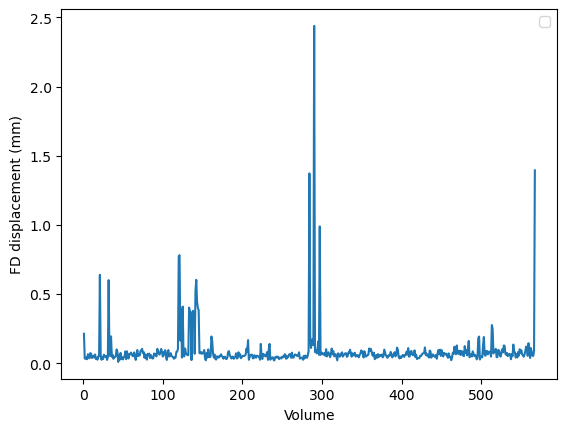

In [14]:
import matplotlib.pyplot as plt
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.legend()
plt.show() #big displacement at the runs switching, to be expected

## (Bonus) Coregistration

In [15]:
coregister_path=op.join(func_preproc_path, 'tfMRI_MOTOR_coregistered')
white_matter_segmentation=op.join(subject_preproc_root,  'T1w','T1w_fasted_pve_2.nii.gz')

use_single_vol: bool = True
if use_single_vol:

    subprocess.run(['epi_reg','--epi={}'.format(reference_path), '--t1={}'.format(anat_path), '--t1brain={}'.format(betted_brain_path), '--out={}'.format(coregister_path),'--wmseg={}'.format(white_matter_segmentation)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(motion_corrected_path), '--t1={}'.format(anat_path), '--t1brain={}'.format(betted_brain_path), '--out={}'.format(coregister_path),'--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
1.018467 0.996950 0.077585 -0.008413 0.000000 -0.078033 0.992439 -0.094736 0.000000 0.000999 0.095103 0.995467 0.000000 16.448204 -15.445828 23.437241 1.000000 


In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anat_path)
fsleyesDisplay.load(coregister_path)

## Smoothing

In [18]:
# motion corrected resolution is 2 x 2 x 2 mm
FMWH=4
source_path = motion_corrected_path
subprocess.run(['fslmaths',source_path, '-s', str(FMWH/2.3548), '{}_smoothed_4mm'.format(source_path)])

CompletedProcess(args=['fslmaths', '/data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_moco', '-s', '1.6986580601324954', '/data/nssp-mp1/dataset/derivatives/preprocessed_data/subject101410/fMRI/tfMRI_MOTOR_moco_smoothed_4mm'], returncode=0)

In [19]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(source_path + "_smoothed_4mm")
fsleyesDisplay.load(source_path)